In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from scipy.interpolate import UnivariateSpline
from fbprophet import Prophet
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# edit graph style here
sns.set()
plt.style.use('seaborn-poster')  # for poster use 'seaborn-poster'

Load in the historical data:

In [3]:
provinces = [10, 41, 50, 70, 90]
province_names = ['Bangkok', 'Udon Thani', 'Ratchaburi', 'Chiang Mai', 'Songkla']
years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

true_data = pd.read_csv('../../data/province-month.csv')
true_data = true_data.loc[true_data['province'].isin(provinces) & true_data['date_sick_year'].isin(years)]
true_data['date_sick'] = true_data['date_sick_year'].map(str) + '-' + true_data['month'].map(str)
true_data['date_sick'] = pd.to_datetime(true_data['date_sick'])

In [11]:
def make_comparison_graph(province, years_since_2007):
    
    provinces = [10, 41, 50, 70, 90]
    province_names = ['Bangkok', 'Udon Thani', 'Ratchaburi', 'Chiang Mai', 'Songkla']
    years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

    true_data = pd.read_csv('../../data/province-month.csv')
    true_data = true_data.loc[true_data['province'].isin(provinces) & true_data['date_sick_year'].isin(years)]
    true_data['date_sick'] = true_data['date_sick_year'].map(str) + '-' + true_data['month'].map(str)
    true_data['date_sick'] = pd.to_datetime(true_data['date_sick'])

    prov = province
    k = years_since_2007

    # load data
    true_data_one_year = true_data.loc[(true_data['date_sick_year'] == 2007+k) & (true_data['province'] == prov) ]
    
    with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
        data_file = pickle.load(file)
    data = data_file[k]
    data['year_month'] = (data['date_sick_year']-2006)*12 + (data['month'])
    df = data.loc[data['province'] == prov]
    
    # make the prophet forecast
    date_sick = np.array(data['date_sick'])
    year = np.array(data['date_sick_year'])
    cases = np.array(data['cases'])

    df = pd.DataFrame(list(zip(date_sick, cases)), columns=['ds', 'y'])

    # fit the prophet model
    model = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df)

    # extend the dataframe and get the predictions
    future_dates = model.make_future_dataframe(periods=12, freq='M')
    past_and_forecast = model.predict(future_dates)
    forecast = past_and_forecast.tail(12)
    
    print(forecast['yhat'])
    
    # make the other prophet model
    date_sick = np.array(data['date_sick'])
    year = np.array(data['date_sick_year'])
    cases = np.array(data['cases'])

    df = pd.DataFrame(list(zip(date_sick, cases)), columns=['ds', 'y'])

    # fit the prophet model
    model = Prophet(changepoint_prior_scale= 0.5, interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df)

    # extend the dataframe and get the predictions
    future_dates = model.make_future_dataframe(periods=12, freq='M')
    past_and_forecast = model.predict(future_dates)
    forecast2 = past_and_forecast.tail(12)
    
    # get monthly average forecasts
    with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
        data_file = pickle.load(file)

    input_data = data_file[k]
    input_data['year_month'] = (input_data['date_sick_year']-2006)*12 + (input_data['month'])

    df = input_data.loc[input_data['province'] == prov]

    true_data = data_file[k+1]
    true_data['year_month'] = (true_data['date_sick_year']-2006)*12 + (true_data['month'])

    true_df = true_data.loc[true_data['province'] == prov]
    true_df['date_sick'] == pd.to_datetime(true_df['date_sick'])
    # print(true_df['cases'])

    x = df['year_month'].tolist()
    y = df['cases'].tolist()

    y_sum = np.cumsum(y)

    spl = UnivariateSpline(x, y_sum)

    y_fit = spl(x)

    y_smooth = np.diff(y_fit)
    n = np.append(y_smooth[::-1], y_sum[0])
    y_smooth = n[::-1]

    df['smooth_cases'] = y_smooth

    df.head()

    monthly_avg = []
    for i in range(1, 13):
        monthly_cases = df['smooth_cases'].loc[df['month'] == i].tolist()
        avg = np.mean(monthly_cases)
        monthly_avg.append(avg)
        
    print(true_data_one_year['cases'])
        
    # make the graph finally
    plt.xlabel('Month')
    plt.ylabel('Cases')
    # plt.title('Forecasted and Actual Cases of DHF in Bangkok in 2014')
    plt.xticks(rotation=45)

    fig = plt.plot(true_data_one_year['date_sick'], true_data_one_year['cases'], '-', forecast['ds'], forecast['yhat'], '--', forecast2['ds'], forecast2['yhat'], '--', forecast['ds'], monthly_avg, '--')
    plt.legend(['historical data', 'prophet w/ default', 'prophet w/ increased flexibility', 'historical averages model'], loc = 'upper_left')
    plt.show()

476    182.523094
477    160.933562
478    139.914868
479    127.501074
480    210.887095
481    298.134513
482    326.846188
483    331.538993
484    293.903619
485    275.075828
486    285.076022
487    213.308829
Name: yhat, dtype: float64
45759    207.0
45821    157.0
45884    130.0
45951     80.0
46015     92.0
46086    140.0
46161    237.0
46236    216.0
46311    319.0
46384    387.0
46456    447.0
46527    271.0
Name: cases, dtype: float64


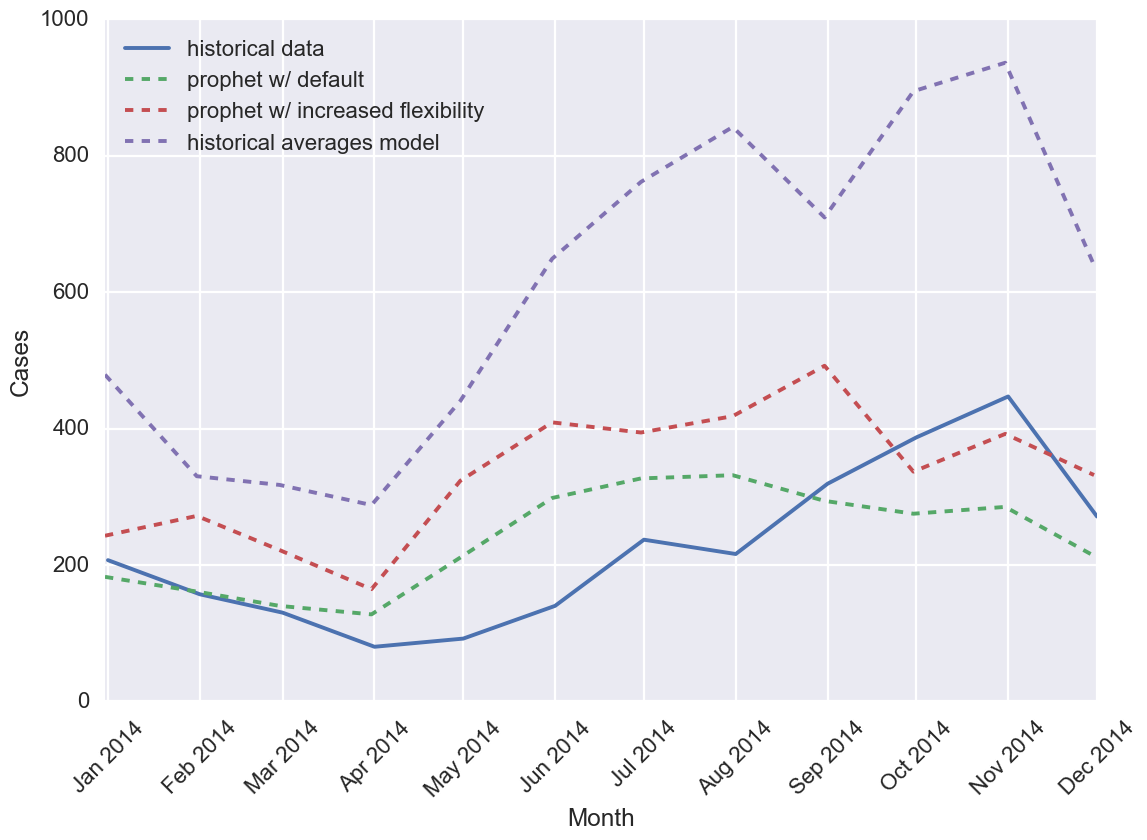

In [12]:
make_comparison_graph(10, 7)

In [54]:
k = 0
prov = 10

true_data_one_year = true_data.loc[(true_data['date_sick_year'] == 2007+k) & (true_data['province'] == prov) ]
print(true_data_one_year.head())

       date_sick_year  month  province  cases  date_sick
39616            2007      1        10  522.0 2007-01-01
39680            2007      2        10  250.0 2007-02-01
39738            2007      3        10  253.0 2007-03-01
39810            2007      4        10  229.0 2007-04-01
39884            2007      5        10  371.0 2007-05-01


Load in the data for Prophet:

In [45]:
with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
    data_file = pickle.load(file)


data = data_file[k]
data['year_month'] = (data['date_sick_year']-2006)*12 + (data['month'])

df = data.loc[data['province'] == prov]
df.tail()

,date_sick_year,month,province,cases,date_sick,year_month
43624,2011,8,10,816.0,2011-8-1,68
43700,2011,9,10,489.0,2011-9-1,69
43775,2011,10,10,558.0,2011-10-1,70
43847,2011,11,10,808.0,2011-11-1,71
43918,2011,12,10,388.0,2011-12-1,72


Make the Prophet forecast for plotting

In [46]:
date_sick = np.array(data['date_sick'])
year = np.array(data['date_sick_year'])
cases = np.array(data['cases'])

df = pd.DataFrame(list(zip(date_sick, cases)), columns=['ds', 'y'])

# fit the prophet model
model = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df)

# extend the dataframe and get the predictions
future_dates = model.make_future_dataframe(periods=12, freq='M')
past_and_forecast = model.predict(future_dates)
forecast = past_and_forecast.tail(12)

Make the other Prophet model for forecasting:

In [47]:
date_sick = np.array(data['date_sick'])
year = np.array(data['date_sick_year'])
cases = np.array(data['cases'])

df = pd.DataFrame(list(zip(date_sick, cases)), columns=['ds', 'y'])

# fit the prophet model
model = Prophet(changepoint_prior_scale= 0.5, interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df)

# extend the dataframe and get the predictions
future_dates = model.make_future_dataframe(periods=12, freq='M')
past_and_forecast = model.predict(future_dates)
forecast2 = past_and_forecast.tail(12)

In [48]:
with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
    data_file = pickle.load(file)

input_data = data_file[k]
input_data['year_month'] = (input_data['date_sick_year']-2006)*12 + (input_data['month'])

df = input_data.loc[input_data['province'] == prov]

true_data = data_file[k+1]
true_data['year_month'] = (true_data['date_sick_year']-2006)*12 + (true_data['month'])

true_df = true_data.loc[true_data['province'] == prov]
true_df['date_sick'] == pd.to_datetime(true_df['date_sick'])
true_df.tail()

x = df['year_month'].tolist()
y = df['cases'].tolist()

y_sum = np.cumsum(y)

spl = UnivariateSpline(x, y_sum)

y_fit = spl(x)

y_smooth = np.diff(y_fit)
n = np.append(y_smooth[::-1], y_sum[0])
y_smooth = n[::-1]

df['smooth_cases'] = y_smooth

df.head()

monthly_avg = []
for i in range(1, 13):
    monthly_cases = df['smooth_cases'].loc[df['month'] == i].tolist()
    avg = np.mean(monthly_cases)
    monthly_avg.append(avg)

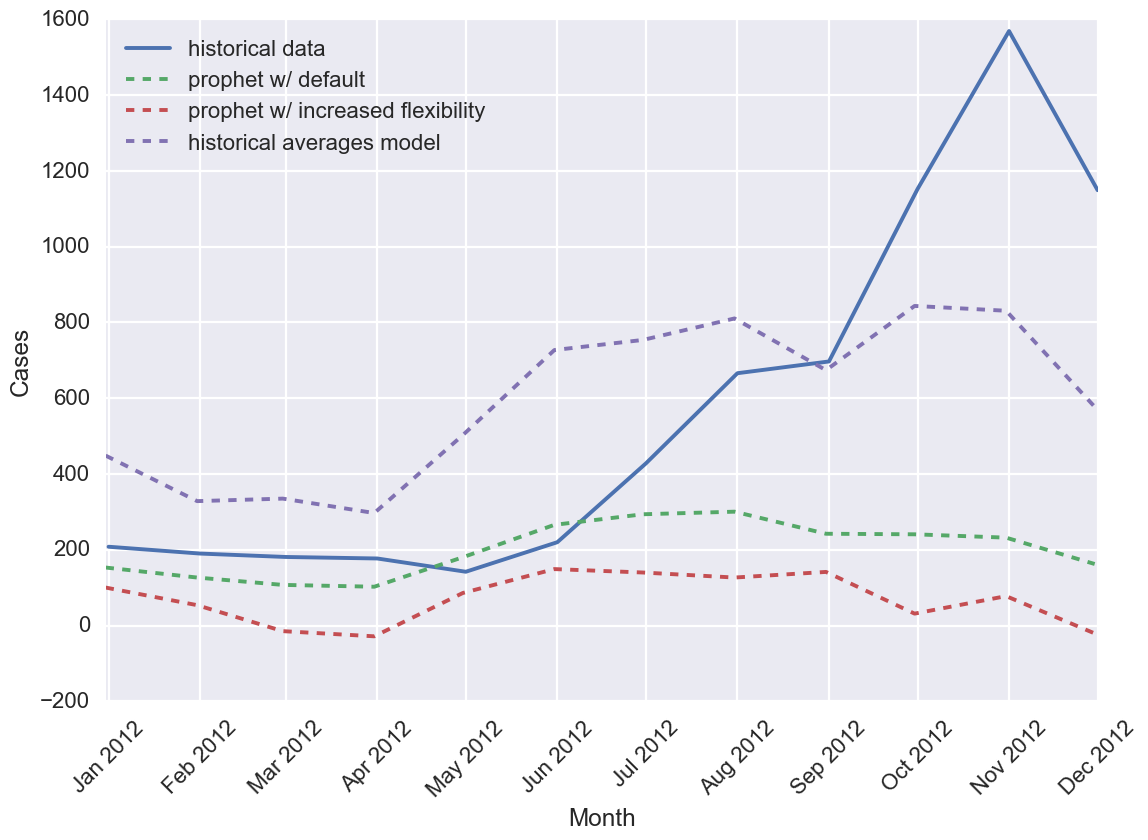

In [51]:
plt.xlabel('Month')
plt.ylabel('Cases')
# plt.title('Forecasted and Actual Cases of DHF in Bangkok in 2014')
plt.xticks(rotation=45)

fig = plt.plot(true_data_one_year['date_sick'], true_data_one_year['cases'], '-', forecast['ds'], forecast['yhat'], '--', forecast2['ds'], forecast2['yhat'], '--', forecast['ds'], monthly_avg, '--')
plt.legend(['historical data', 'prophet w/ default', 'prophet w/ increased flexibility', 'historical averages model'], loc = 'upper_left')
plt.show()

In [50]:
with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
    data_file = pickle.load(file)
    
dataaa = pd.read_csv('../../data/province-month.csv')


input_data = data_file[k]
input_data['year_month'] = (input_data['date_sick_year']-2006)*12 + (input_data['month'])

df = input_data.loc[input_data['province'] == prov]

true_data = data_file[k+1]
true_data['year_month'] = (true_data['date_sick_year']-2006)*12 + (true_data['month'])
true_df = true_data.loc[true_data['province'] == prov]
true_df['date_sick'] == pd.to_datetime(true_df['date_sick'])

x = df['year_month'].tolist()
y = df['cases'].tolist()

y_sum = np.cumsum(y)

spl = UnivariateSpline(x, y_sum)

y_fit = spl(x)

y_smooth = np.diff(y_fit)
n = np.append(y_smooth[::-1], y_sum[0])
y_smooth = n[::-1]

df['smooth_cases'] = y_smooth

df.head()

monthly_avg = []
for i in range(1, 13):
    monthly_cases = df['smooth_cases'].loc[df['month'] == i].tolist()
    avg = np.mean(monthly_cases)
    monthly_avg.append(avg)

In [114]:
true_data_one_year = true_data.loc[(true_data['date_sick_year'] == 2007+k) & (true_data['province'] == prov)]
true_data_pre_year = true_data.loc[(true_data['date_sick_year'] == 2007+(k-1)) & (true_data['month'] > 10) & (true_data['province'] == prov)]

true_data = true_data_pre_year.append(true_data_one_year)
true_data['date_sick'] = pd.to_datetime(true_data['date_sick'])

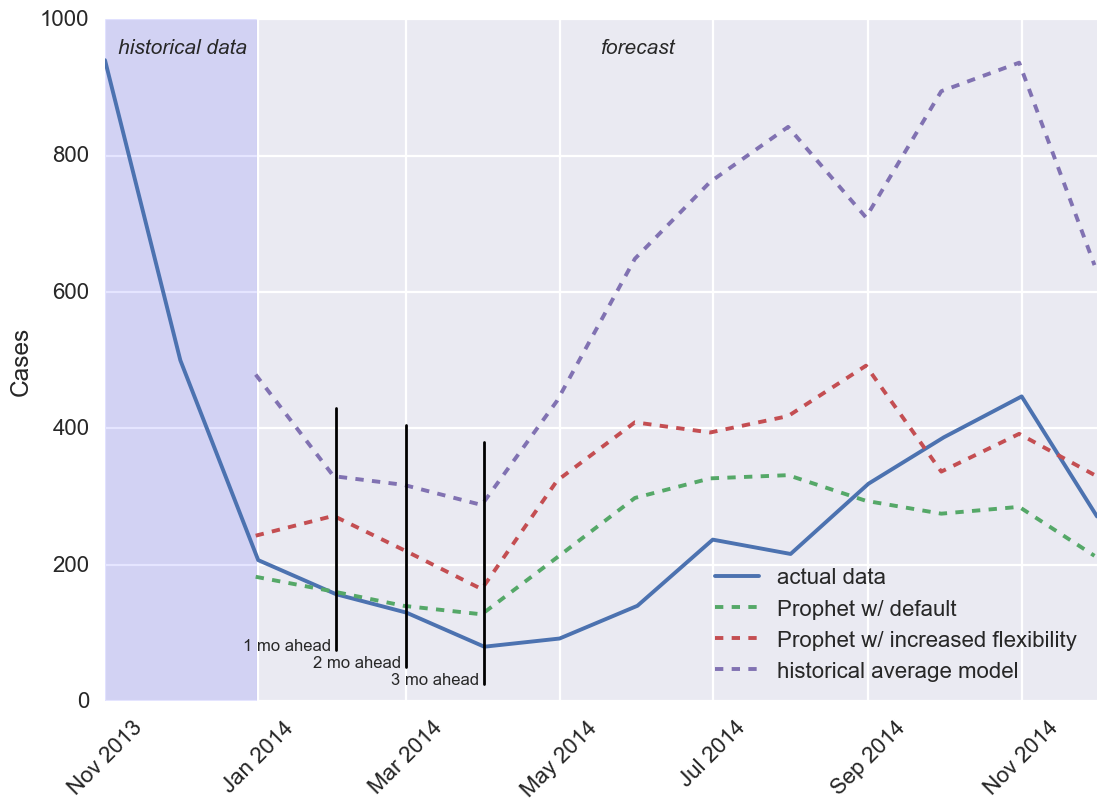

In [168]:
plt.ylabel('Cases')
# plt.title('Forecasted and Actual Cases of DHF in Bangkok in 2014')
plt.xticks(rotation=45)


fig = plt.plot(true_data['date_sick'], true_data['cases'], '-', forecast['ds'], forecast['yhat'], '--', forecast2['ds'], forecast2['yhat'], '--', forecast['ds'], monthly_avg, '--')
plt.legend(['actual data', 'Prophet w/ default', 'Prophet w/ increased flexibility', 'historical average model'], loc = 'upper_left')

from dateutil import parser
dt = parser.parse("Dec 31 2013")
dt_start = parser.parse('Nov 1 2013')
plt.axvspan(dt_start, dt, alpha=0.1, color='blue')

dt_label = parser.parse('Nov 06 2013')
plt.text(dt_label, 950, 'historical data', size=15, style='italic')

dt_label = parser.parse('May 17 2014')
plt.text(dt_label, 950, 'forecast', size=15, style='italic')

dt_1step = parser.parse('Feb 01 2014')
plt.axvline(dt_1step, ymin=0.075, ymax=0.43, c='black', lw=2)

dt_2step = parser.parse('Mar 01 2014')
plt.axvline(dt_2step, ymin=0.05, ymax=0.405, c='black', lw=2)

dt_3step = parser.parse('Apr 01 2014')
plt.axvline(dt_3step, ymin=0.025, ymax=0.38, c='black', lw=2)

dt_1step_text = parser.parse('Dec 26 2013')
plt.text(dt_1step_text, 75, '1 mo ahead')

dt_2step_text = parser.parse('Jan 23 2014')
plt.text(dt_2step_text, 50, '2 mo ahead')

dt_3step_text = parser.parse('Feb 23 2014')
plt.text(dt_3step_text, 25, '3 mo ahead')

plt.show()

In [188]:
prophet1_resid = np.round(np.sqrt((np.array(true_data_one_year['cases']) - np.array(forecast['yhat']))**2))
print(prophet1_resid)

prophet2_resid = np.round(np.sqrt((np.array(true_data_one_year['cases']) - np.array(forecast2['yhat']))**2))
print(prophet2_resid)

histavg_resid = np.round(np.sqrt((np.array(true_data_one_year['cases']) - np.array(monthly_avg))**2))
print(histavg_resid)

[  24.    4.   10.   48.  119.  158.   90.  116.   25.  112.  162.   58.]
[  36.  115.   92.   84.  231.  269.  157.  202.  173.   50.   55.   61.]
[ 272.  173.  187.  208.  349.  509.  525.  626.  391.  508.  489.  369.]


In [192]:
print(str(prophet1_resid.tolist()).replace(',', ' &').replace('.0', ''))
print(str(prophet2_resid.tolist()).replace(',', ' &').replace('.0', ''))
print(str(histavg_resid.tolist()).replace(',', ' &').replace('.0', ''))

[24 & 4 & 10 & 48 & 119 & 158 & 90 & 116 & 25 & 112 & 162 & 58]
[36 & 115 & 92 & 84 & 231 & 269 & 157 & 202 & 173 & 50 & 55 & 61]
[272 & 173 & 187 & 208 & 349 & 509 & 525 & 626 & 391 & 508 & 489 & 369]
